## Age and Gender Prediction Using CNN.


### In this project, we will be performing both classification and regression to predict both gender and age respectively.


In [128]:
# Standard library imports
import os 
import warnings 

# Third-party imports
import random
import numpy as np
from PIL import Image
import seaborn as sns
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.utils import load_img  # type: ignore
from keras.models import Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from keras.preprocessing.image import load_img

# Configurations
warnings.filterwarnings('ignore')
%matplotlib inline

## Load the dataset


In [119]:
BASE_DIR = '../archive/UTKFace'

In [120]:
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
    image_path = os.path.join(BASE_DIR, image)
    img_components = image.split('_')
    age_label = int(img_components[0])
    gender_label = int(img_components[1])

    # Append the image_path, age_label, and gender_label
    age_labels.append(age_label)
    gender_labels.append(gender_label)
    image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [121]:
print(f'Number of age_labels: {len(age_labels)} \nNumber of gender_labels: {len(gender_labels)} \nNumber of image_paths: {len(image_paths)}')

Number of age_labels: 23708 
Number of gender_labels: 23708 
Number of image_paths: 23708


In [122]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [6]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,../archive/UTKFace\26_1_4_20170117201457622.jp...,26,1
1,../archive/UTKFace\26_1_3_20170104222600591.jp...,26,1
2,../archive/UTKFace\48_0_0_20170104193619832.jp...,48,0
3,../archive/UTKFace\45_0_3_20170119184244311.jp...,45,0
4,../archive/UTKFace\26_0_1_20170113133114391.jp...,26,0


## Exploratory Data Anlysis


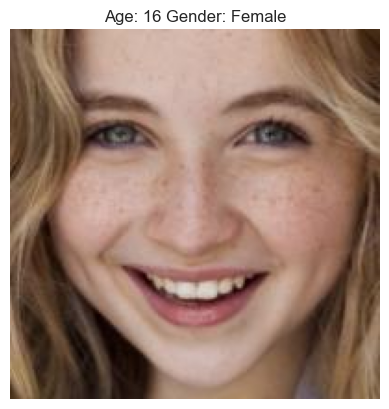

In [117]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

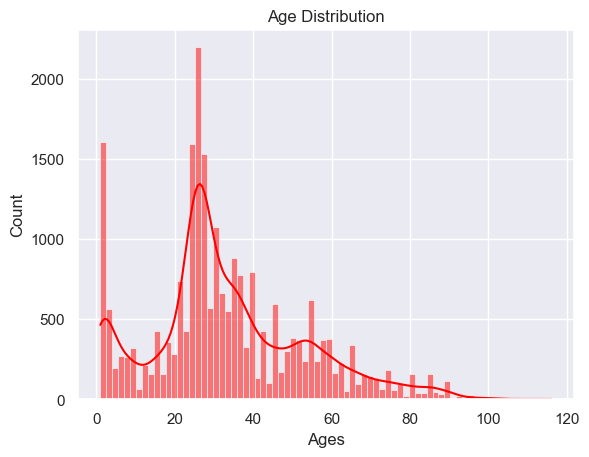

In [109]:
# Age distribution
sns.set_theme()
plt.title('Age Distribution')
sns.histplot(df['age'], kde=True, color='red')
plt.xlabel('Ages')
plt.show()

Text(0.5, 0, 'Gender [0=Male, 1=Female]')

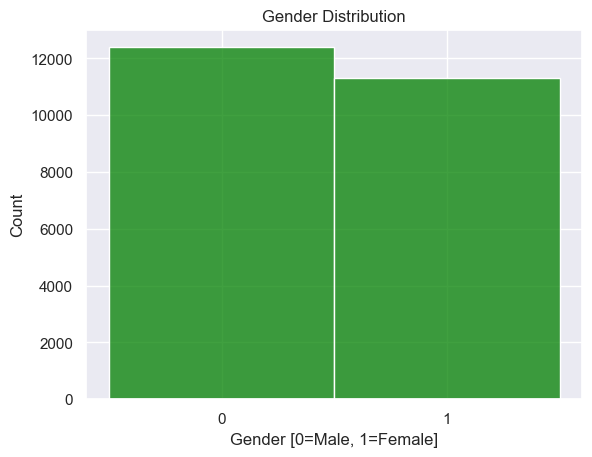

In [127]:
# Gender distribution
sns.histplot(df['gender'], discrete=True, color='green')
plt.title('Gender Distribution')
plt.xticks([0, 1])
plt.xlabel('Gender [0=Male, 1=Female]')

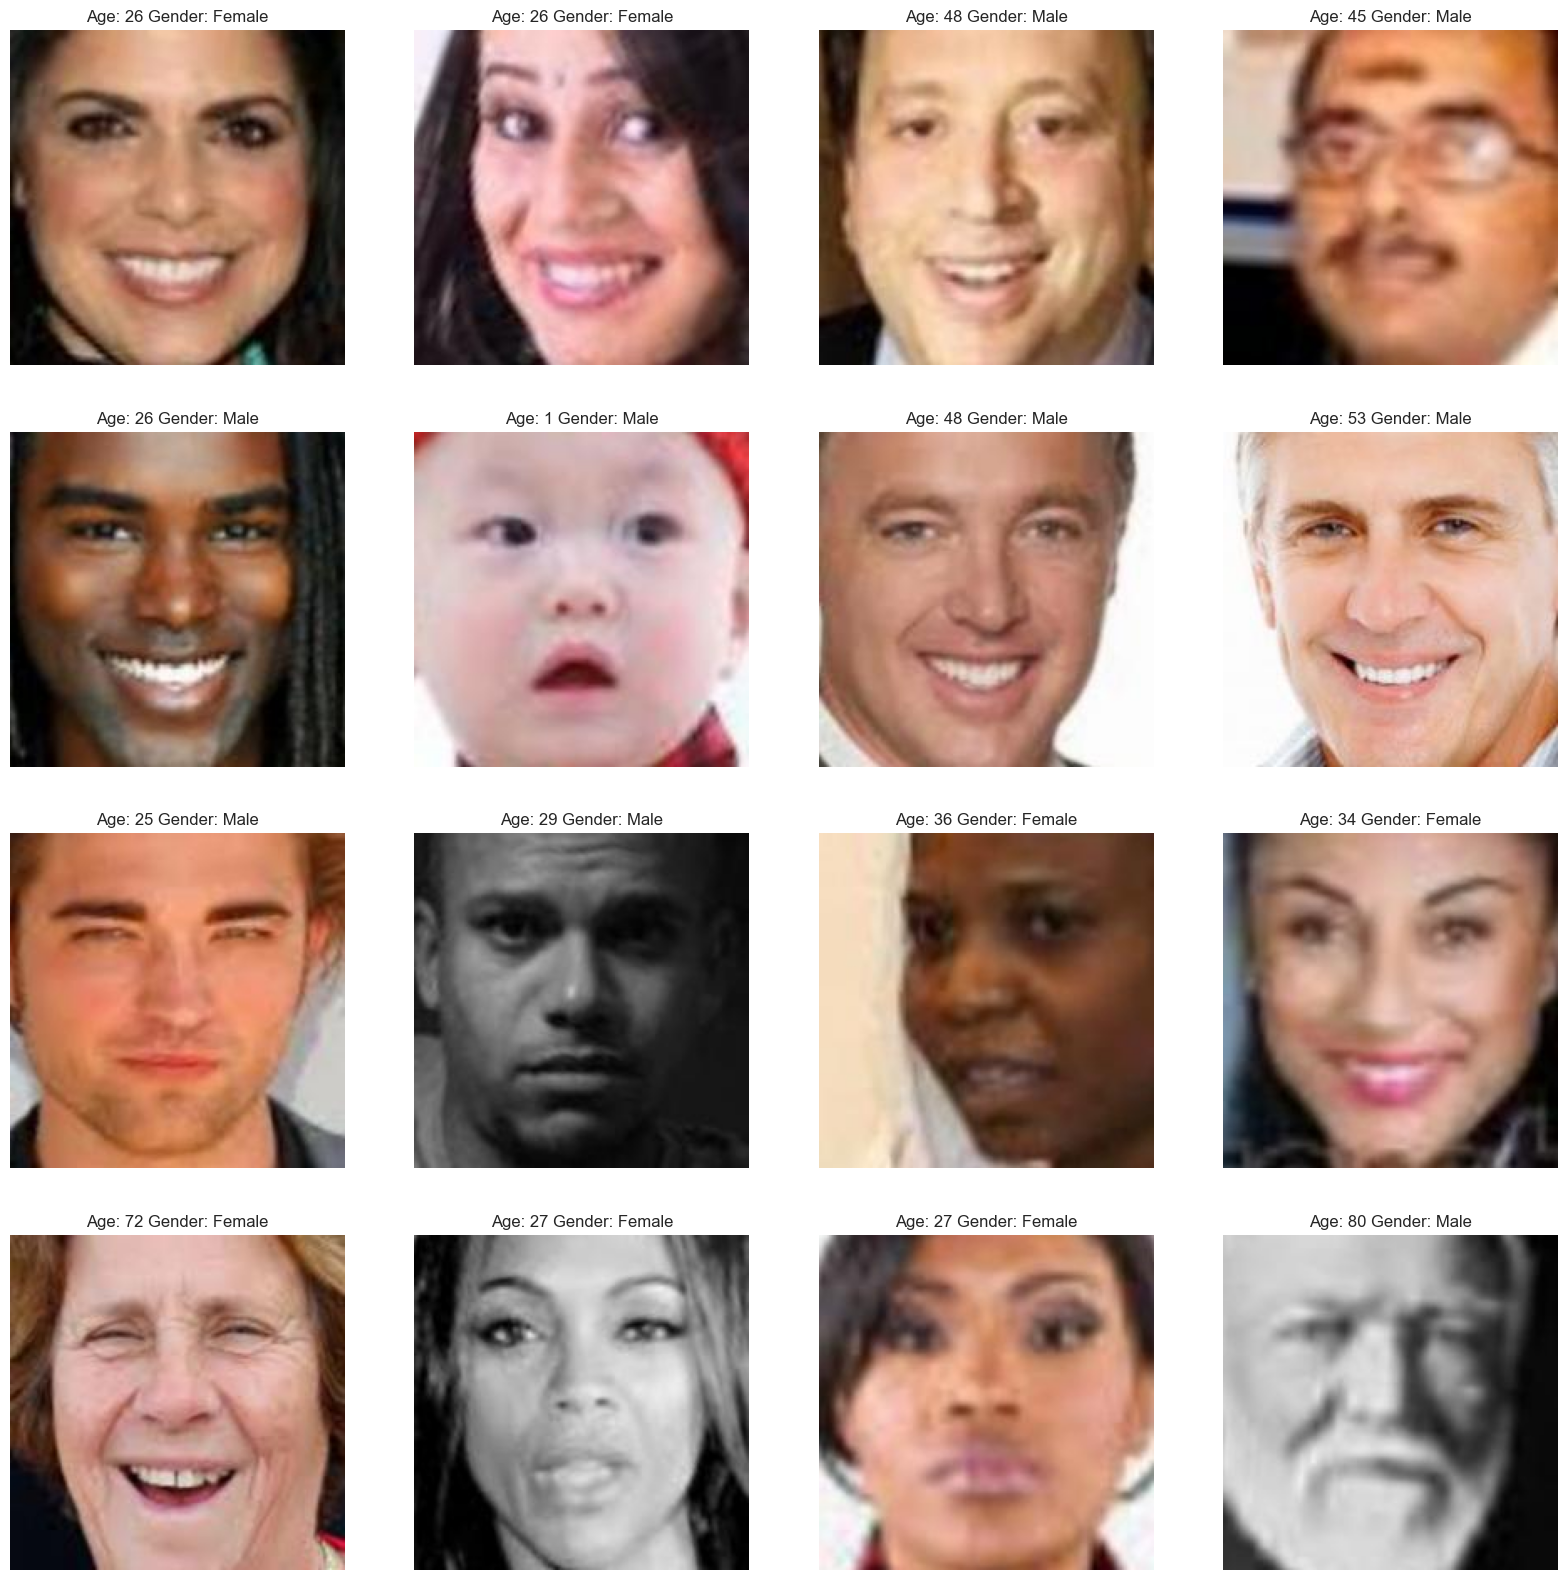

In [118]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

## Feature Extraction


In [23]:
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array

def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale') 
        img = img.resize((128, 128), Image.LANCZOS)  
        img = img_to_array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [24]:
X = extract_image_features(df['image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [25]:
X.shape

(23708, 128, 128, 1)

In [26]:
X = X / 255.0

In [27]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [28]:
input_shape = (128, 128, 1)

In [29]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy'])

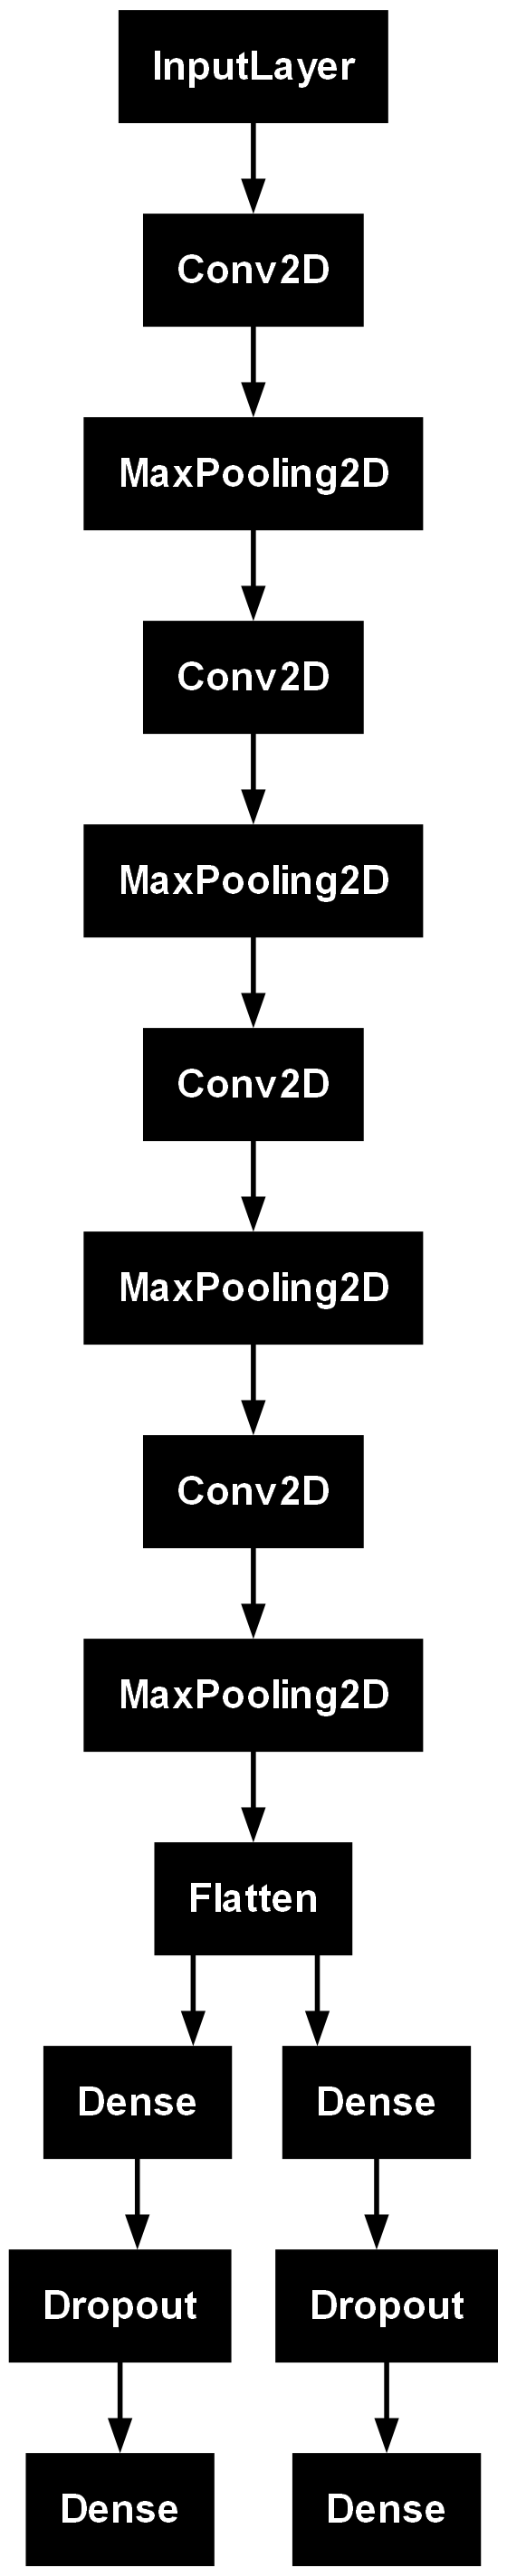

In [30]:
# plot the model
from tensorflow.keras.utils import plot_model # type: ignore
plot_model(model)

# Model Training

In [32]:
# Compile the model
model.compile(optimizer='adam', 
              loss=['binary_crossentropy', 'mse'], 
              metrics=[['accuracy'], ['mse']])

# Train the model
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=50, validation_split=0.2)

print("Model training completed.")

Epoch 1/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 197s 326ms/step - age_out_mse: 463.6423 - gender_out_accuracy: 0.5252 - loss: 464.3590 - val_age_out_mse: 262.2048 - val_gender_out_accuracy: 0.7450 - val_loss: 261.7095
Epoch 2/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 164s 276ms/step - age_out_mse: 222.8422 - gender_out_accuracy: 0.7443 - loss: 223.3600 - val_age_out_mse: 179.3708 - val_gender_out_accuracy: 0.7929 - val_loss: 179.1722
Epoch 3/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 164s 277ms/step - age_out_mse: 163.7409 - gender_out_accuracy: 0.7871 - loss: 164.1890 - val_age_out_mse: 129.6582 - val_gender_out_accuracy: 0.8275 - val_loss: 129.6952
Epoch 4/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 162s 273ms/step - age_out_mse: 128.7399 - gender_out_accuracy: 0.8138 - loss: 129.1390 - val_age_out_mse: 120.3382 - val_gender_out_accuracy: 0.8412 - val_loss: 120.2765
Epoch 5/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 162s 273ms/step - age_out_mse: 107.5220 - gender_out_accuracy: 0.8289 - loss: 107.8928 - val_age_out_mse: 104.5444 - val

## Plot the Results


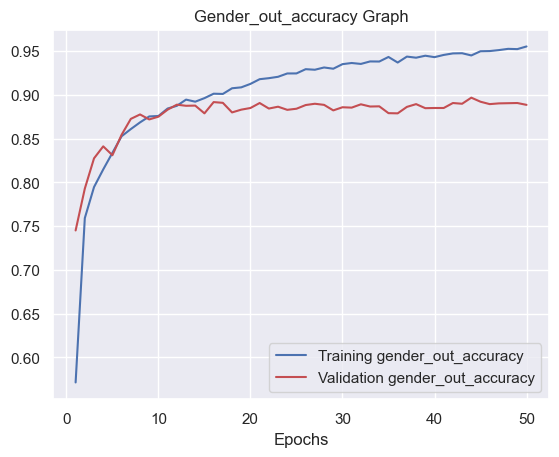

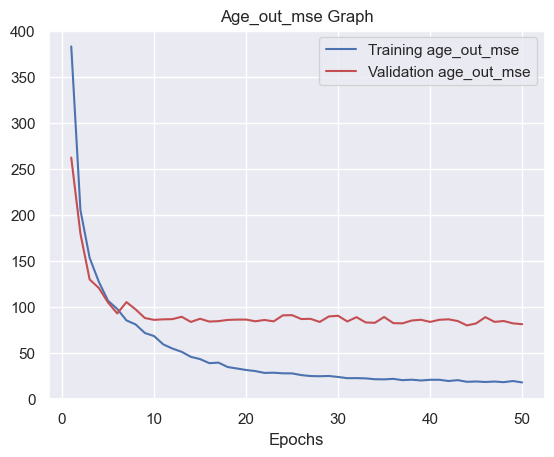

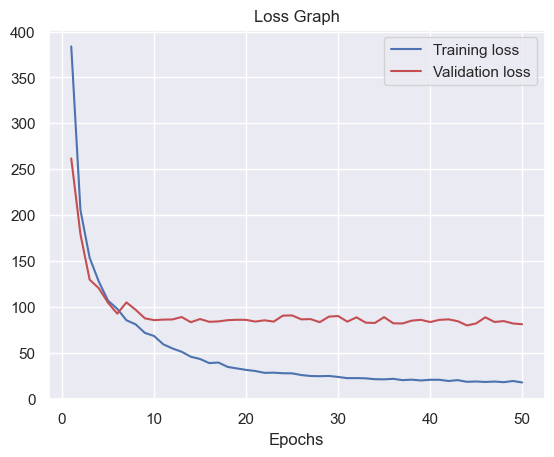

<Figure size 640x480 with 0 Axes>

In [98]:
def plot_graphs(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)

    plt.plot(epochs, train_metrics, 'b', label='Training ' + metric)
    plt.plot(epochs, val_metrics, 'r', label='Validation ' + metric)
    plt.title(metric.capitalize() + ' Graph')
    plt.xlabel('Epochs')
    plt.legend()
    plt.figure()

# Plot accuracy graph for gender
plot_graphs(history, 'gender_out_accuracy')
plot_graphs(history, 'age_out_mse')

# Plot loss graph for the entire model
plot_graphs(history, 'loss')

plt.show()

# Model Summary

In [79]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 9216)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,322,376 (58.45 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,214,918 (38.97 MB)

## Predicting Test Data


In [42]:
def get_image_features(image):
    img = load_img(image, color_mode='grayscale')  # Use color_mode instead of grayscale
    img = img.resize((128, 128), Image.LANCZOS)  # Use Image.ANTIALIAS
    img = np.array(img)
    img = img.reshape(1, 128, 128, 1)
    img = img / 255.0
    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


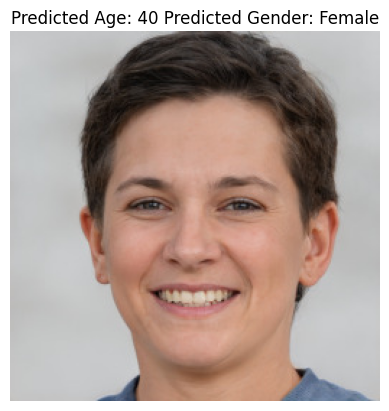

In [78]:
img_to_test = 'test_data/45tyw4sh.jpg'
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))

In [56]:
# save model for streamlit
model.save('age_gender_detection_model.keras')